# MACD背离策略

In [2]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 回测框架
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeed

# 基础函数
import utilsJ

## 策略

### 数据槽

In [3]:
class Data_MACD(btfeed.PandasData):
    '''
    The ``dataname`` parameter inherited from ``feed.DataBase`` is the pandas
    DataFrame
    '''
    lines = ('MA5','DIFF','DEA','MACD',
    )

    params = (
        # Possible values for datetime (must always be present)
        #  None : datetime is the "index" in the Pandas Dataframe
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('datetime', None),

        # Possible values below:
        #  None : column not present
        #  -1 : autodetect position or case-wise equal name
        #  >= 0 : numeric index to the colum in the pandas dataframe
        #  string : column name (as index) in the pandas dataframe
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('MA5', -1),
        ('DIFF', -1), 
        ('DEA', -1),
        ('MACD', -1),
    )

### 策略主体

In [33]:
class MACD(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('stake', 100),
        ('allow_short', False),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.p.printlog or doprint:
            dt = dt or self.datas[0].datetime.datetime(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
            #    file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        
        # Initialization
        self.order = None
        self.buyprice = None
        self.sellprice = None
        self.ava_pos = 0
        self.buy_forzen = 0
        self.sell_forzen = 0
        
        # Alias
        self.dataclose = self.data.close
        self.datahigh = self.data.high
        self.datalow = self.data.low
        self.MACD = self.data.MACD
        self.MA5 = self.data.MA5

        # Indicators
        ## Plotting issue
        self.MACD_P = btind.MACDHisto(self.dataclose)
        self.MA5_P = btind.SMA(self.dataclose, period=5)
        self.macd_peak = bt.And(self.MACD < self.MACD(-1), 
                                self.MACD(-2) < self.MACD(-1))
        self.macd_peak_value = np.zeros(2)
        self.macd_bottom = bt.And(self.MACD > self.MACD(-1), 
                                  self.MACD(-2) > self.MACD(-1))
        self.macd_bottom_value = np.zeros(2)
        self.price_peak = bt.And(self.datahigh < self.datahigh(-1),
                                 self.datahigh(-2) < self.datahigh(-1))
        self.price_peak_value = np.zeros(2)
        self.price_bottom = bt.And(self.datalow > self.datalow(-1),
                                 self.datalow(-2) < self.datalow(-1))
        self.price_bottom_value = np.zeros(2)


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Price: %.2f, Lot:%i, Cash: %i' %
                         (order.executed.price, order.executed.size,
                          self.broker.get_cash()))
                self.buyprice = order.executed.price
                self.buy_forzen += order.executed.size

            else:
                self.log('SELL EXECUTED, Price: %.2f, Lot:%i, Cash: %i' %
                        (order.executed.price, -order.executed.size,
                         self.broker.get_cash()))
                self.sellprice = order.executed.price
                self.ava_pos += order.executed.size
                self.sell_forzen += order.executed.size
        
        self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        
    def next(self):
        
        if self.order:
            return
        
        if self.data.datetime.time() == dt.time(9,30):
            self.ava_pos += self.buy_forzen
            self.buy_forzen = 0
            self.sell_forzen = 0
    
    
        # Record peak/bottom values
        if self.macd_peak[0]:
            if self.macd_peak_value[0] != 0:
                self.macd_peak_value[1] = self.macd_peak_value[0]
            self.macd_peak_value[0] = self.MACD[0]
        
        if self.macd_bottom[0]:
            if self.macd_bottom_value[0] != 0:
                self.macd_bottom_value[1] = self.macd_bottom_value[0]
            self.macd_bottom_value[0] = self.MACD[0]
        
        if self.price_peak[0]:
            if self.price_peak_value[0] != 0:
                self.price_peak_value[1] = self.price_peak_value[0]
            self.price_peak_value[0] = self.datahigh[0]
        
        if self.price_bottom[0]:
            if self.price_bottom_value[0] != 0:
                self.price_bottom_value[1] = self.price_bottom_value[0]
            self.price_bottom_value[0] = self.datalow[0]
        
        # Signals
        buy_s = self.price_bottom_value[0] < self.price_bottom_value[1] and \
                self.macd_bottom_value[0] > self.macd_bottom_value[1] and \
                self.macd_peak_value[0] > self.macd_peak_value[1]
                    
        
        sell_s = self.price_peak_value[0] > self.price_peak_value[1] and \
                self.macd_peak_value[0] < self.macd_peak_value[1] and \
                self.macd_bottom_value[0] < self.macd_bottom_value[1]
        
        ava_pos = self.broker.get_cash() // (self.dataclose[0] * self.p.stake) * self.p.stake

        if buy_s and self.dataclose[0] > self.MA5[0]:
            if self.ava_pos == 0 and self.buy_forzen == 0: # Open position
                self.log('BUY CREATE, Price: %.2f, Lots: %i' %
                         (self.dataclose[0], ava_pos))
                self.order = self.buy(size=ava_pos)
            elif self.ava_pos < 0: # Close position
                self.log('BUY CREATE (Close), Price: %.2f, Lots: %i' %
                         (self.dataclose[0], -self.free_pos))
                self.order = self.sell(size=self.free_pos)

        elif sell_s:
            if self.ava_pos == 0 and self.buy_forzen == 0 and self.p.allow_short: # Open position
                self.log('SELL CREATE, Price: %.2f, Lots: %i' %
                         (self.dataclose[0], ava_pos))
                self.order = self.buy(size=-ava_pos)
            elif self.ava_pos > 0: # Close position
                self.log('SELL CREATE (Close), Price: %.2f, Lots: %i' %
                         (self.dataclose[0], self.ava_pos))
                self.order = self.sell(size=self.ava_pos)
        

## 回测

### 单股测试

In [35]:
stock_code = '601012.SH'
startdate = dt.datetime(2020,1,1) - dt.timedelta(days=20)
enddate = dt.datetime(2020,12,31)


if __name__ ==  '__main__':
    # Initialization
    cerebro = bt.Cerebro()
    strats = cerebro.addstrategy(MACD, printlog=False) 

    # Data
    df = utilsJ.get_stock(stock_code, startdate, enddate, path='.\\Data\\17-21_30min\\')
    data = Data_MACD(dataname=df,fromdate=startdate,todate=enddate)
    cerebro.adddata(data)

    # Start condition
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(10000)
    #cerebro.broker.setcommission()
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Execution
    cerebro.run()

    # Final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    cerebro.plot(iplot=False)

Starting Portfolio Value: 10000.00
Final Portfolio Value: 11863.90


### 沪深300成分测试

In [ ]:
index_code = '399300.SZ'
startdate = dt.datetime(2020,1,1) - dt.timedelta(days=20)
enddate = dt.datetime(2020,12,31)

if __name__ == '__main__':

    index_list = utilsJ.get_index_components(index_code, startdate, enddate)
    profit_stk = dict()
    for stk in index_list:
        # Initialization
        
        cerebro = bt.Cerebro()
        strats = cerebro.addstrategy(MACD) 

        # Data
        df = utilsJ.get_stock(stk, startdate, enddate, path='.\\Data\\17-21_30min\\')
        data = Data_MACD(dataname=df,fromdate=startdate,todate=enddate)
        cerebro.adddata(data)

        # Start condition
        cerebro.broker = bt.brokers.BackBroker(coc=True)   
        cerebro.broker.setcash(1000000)
        #cerebro.broker.setcommission()
        start_value = cerebro.broker.getvalue()
        #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Execution
        cerebro.run()

        # Final result
        final_value = cerebro.broker.getvalue()
        #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('%s, Net Profit: %.2f%%' % (stk,(final_value - start_value) / start_value * 100))
        profit_stk[stk] = (final_value - start_value) / start_value * 100

In [41]:
np.mean([float(x) for x in profit_stk.values()])

8.622839181556195

In [49]:
sorted(profit_stk.items(), key=lambda x: x[1], reverse=True)

[('688036.SH', 152.96625600000004),
 ('002371.SZ', 145.2635609999999),
 ('002594.SZ', 132.0741420000001),
 ('600733.SH', 121.9285),
 ('300433.SZ', 113.82989499999994),
 ('601788.SH', 111.35726300000005),
 ('300347.SZ', 97.045877),
 ('002600.SZ', 95.70857600000002),
 ('300122.SZ', 92.5985269999999),
 ('000938.SZ', 90.22570799999995),
 ('601633.SH', 90.15949800000003),
 ('603369.SH', 84.59625399999999),
 ('600570.SH', 76.93774100000002),
 ('002812.SZ', 73.84390800000006),
 ('002050.SZ', 69.32916699999997),
 ('600660.SH', 66.02395300000002),
 ('601108.SH', 63.981647000000066),
 ('603259.SH', 60.488127000000006),
 ('601238.SH', 58.56595300000005),
 ('603501.SH', 56.632857999999985),
 ('000596.SZ', 56.02041200000001),
 ('000157.SZ', 55.79924000000002),
 ('603799.SH', 53.50789999999995),
 ('000768.SZ', 48.772647),
 ('002129.SZ', 48.48006600000011),
 ('600438.SH', 47.25768100000003),
 ('300070.SZ', 46.280370999999974),
 ('603019.SH', 45.03449900000007),
 ('600196.SH', 43.57794600000005),
 ('6

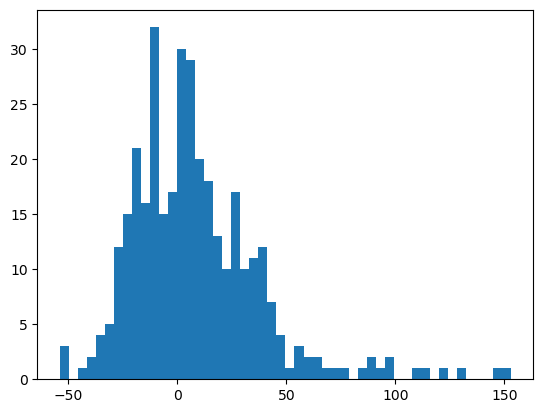

In [47]:
%matplotlib inline
plt.hist([float(x) for x in profit_stk.values()], bins=50)
plt.show()